# DQN for Atari Pacman

In this Notebook, we will explore the Fitted Q-Iteration algorithm with a replay buffer and a target network, which defines the so-called DQN algorithm:

1. Take action $a_j$ w.r.t. some policy (e.g. $\varepsilon$-greedy w.r.t. $Q_\varphi$). Observe transition $(s_j, a_j, r_j, s'_j)$ and add it in the Buffer $B$; 
2. Sample a minibatch of transitions $\{(s_j, a_j, r_j, s'_j)\}_j$ from $B$; 
3. Compute $y_j = r(s_j,a_j) + \gamma\max_{a'_j}Q_{ \varphi'}(s'_j,a'_j)$ using the **target network** $Q_{ \varphi'}$;
4. Update parameters of main network:
$\varphi\leftarrow \varphi - \alpha \sum_j \left[\nabla_\varphi Q_\varphi(s_j,a_j)\right]\left(Q_\varphi(s_j,a_j) - y_j\right)$;
5. Update target network $\varphi'\leftarrow \varphi$.

We apply the algorithm to teach an RL agent play the Atari video game *Pacman* from images of the screen. <br><br>

Since DQN is quite time consuming, this notebook is to be run on from Google Colab with a GPU runtime type. For the same reasons, your goal is to explore the main part of the algorithm ahead of time. Running the training takes about 5 hours using a GPU runtime to produce a mean reward/score of about 2000 per episode. 


<br>
--------------------------

*Many thanks to Jiahao Yao from UC Berkeley for helping me prepare this notebook!*

## Setup

You will need to make a copy of this notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.

In [1]:
#@title Jax with TPU 

#@markdown *(uncomment and run this block first)*

#@markdown **CAVEAT:** this is currently slower than GPU, but this will supposedly change very soon: see this [notebook](https://github.com/google/jax/blob/master/cloud_tpu_colabs/JAX_NeurIPS_2020_demo.ipynb) and this [NeurIPS 2020 video](https://drive.google.com/file/d/1jKxefZT1xJDUxMman6qrQVed7vWI0MIn/view). 

# # get the latest JAX and jaxlib
# !pip install --upgrade -q jax jaxlib

# # Colab runtime set to TPU accel
# import requests
# import os
# if 'TPU_DRIVER_MODE' not in globals():
#   url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
#   resp = requests.post(url)
#   TPU_DRIVER_MODE = 1

# # TPU driver as backend for JAX
# from jax.config import config
# config.FLAGS.jax_xla_backend = "tpu_driver"
# config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
# print(config.FLAGS.jax_backend_target)

In [2]:
#@title mount your Google Drive
#@markdown Your work will be stored in a folder called `DQN_atari` by default to prevent Colab instance timeouts from deleting your edits.

import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#@title Atari Environments 
#@markdown We will use the Gym Pacman environment.

env_name = 'pacman' 
gym_name_map = {
    'pacman': 'MsPacman-v0', 
}
gym_name = gym_name_map[env_name]
print('Gym Env:', gym_name)

Gym Env: MsPacman-v0


In [4]:
#@title set up mount symlink
%cd /content
DRIVE_PATH = '/content/gdrive/My\ Drive/DQN_atari'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH


## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/DQN_atari'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

%cd $SYM_PATH

/content
/content/gdrive/My Drive/DQN_atari


In [5]:
#@title apt install requirements

#@markdown Run each section with Shift+Enter

#@markdown Double-click on section headers to show code.

#@markdown If you see some ERRORs, they are caused by dependencies which are preinstalled in Google Colab; you may ignore them. 

!apt update 
!apt install -y --no-install-recommends \
        build-essential \
        curl \
        git \
        gnupg2 \
        make \
        cmake \
        ffmpeg \
        swig \
        libz-dev \
        unzip \
        zlib1g-dev \
        libglfw3 \
        libglfw3-dev \
        libxrandr2 \
        libxinerama-dev \
        libxi6 \
        libxcursor-dev \
        libgl1-mesa-dev \
        libgl1-mesa-glx \
        libglew-dev \
        libosmesa6-dev \
        lsb-release \
        ack-grep \
        patchelf \
        wget \
        xpra \
        xserver-xorg-dev \
        xvfb \
        python-opengl \
        ffmpeg > /dev/null 2>&1

!pip install opencv-python==3.4.0.12

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [40.7 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease

In [6]:
#@title download the JAX DQN_pacman codebase 
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# download the DQN_pacman codebase -- DO NOT MODIFY THIS CELL
gdd.download_file_from_google_drive(file_id='1TXLk-eeKwuaxrhc7gYLhw4VE94Il6zl_', 
                                    dest_path='./DQN_pacman.tar.gz', 
                                    unzip=True, 
                                    )

# install JAX DQN codebase requirements from requirements_colab.txt 
%pip install -r requirements_colab.txt 
expt_dir = '/content/DQN_atari/'
video_path = os.path.join(expt_dir, 'video')
os.chdir(expt_dir)
!pwd

required_files = ['atari_wrappers.py', 
                  'buffer.py', 'main.py', 
                  'NN.py', 'env_utils.py', 
                  'colab_utils.py', 
                  'video_utils.py',
                  ]
for f in required_files:
  assert os.path.isfile(f)


     |████████████████████████████████| 1.6MB 6.9MB/s 
     |████████████████████████████████| 450kB 17.5MB/s 
  Created wheel for gym: filename=gym-0.17.2-cp36-none-any.whl size=1650891 sha256=af0e5507afaaa84689c21e9e9ea732b5a2b2a6709bad1c0ac7cb363431e975f6
  Stored in directory: /root/.cache/pip/wheels/87/e0/91/f56e44e8062f8cd549673da49f59e1d4fe8b17398119b1d221
Successfully built gym
ERROR: dopamine-rl 1.0.5 has requirement opencv-python>=3.4.1.15, but you'll have opencv-python 3.4.0.12 which is incompatible.
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
/content/gdrive/My Drive/DQN_atari


In [7]:
#@title set up virtual display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

# For later
from colab_utils import (
    wrap_env_demo,
    show_video_demo, 
    show_video
)


In [8]:
#@title test virtual display

#@markdown If you see a video, setup is complete!

import gym
import matplotlib

env = wrap_env_demo(gym.make(gym_name))

observation = env.reset()
for i in range(10):
    env.render(mode='rgb_array')
    obs, rew, term, _ = env.step(env.action_space.sample() ) 
    if term:
      break;
            
env.close()
print('Loading video...')
show_video_demo()

Loading video...


In [9]:
#@title imports

import os.path as osp
import sys, time
from functools import partial

import gym
from gym import wrappers

import numpy as np
import random

from atari_wrappers import *
from buffer import ReplayBuffer

from NN import Neural_Net
from env_utils import episode_step
from video_utils import learning_logger

%load_ext autoreload
%autoreload 2

In [10]:
#@title hyperparameters

#@markdown Set the seed and define the hyperparameters for DQN.

# seed
seed = 0
np.random.seed(seed)
random.seed(seed)
np.random.RandomState(seed)

# Q-learning & network
N_iterations = 3000000 # 200 #   

# discount factor
gamma = 0.99

# Q network update frequency
update_frequency = 4

# frame history length
agent_history_length = 4


use_target = True
# target network update frequency
target_update = 10000 # 100 # 
minibatch_size = 32

# replay buffer parameters
replay_memory_size = 1000000 # 10000 # 

# buffer prefilling steps
replay_start_size = 50000 # 500 # 

# adam parameters
step_size = 1e-4
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_eps = 1e-4
adam_params=dict(N_iterations=N_iterations,
                step_size=step_size,
                b1=adam_beta1,
                b2=adam_beta2,
                eps=adam_eps,
                )

# exploration (epsilon-greedy) schedule
eps_schedule_step = [0, 1e6, 2.5e6]
#eps_schedule_val = [1.0, 0.1, 0.01]
eps_schedule_val = [0.2, 0.1, 0.01]
eps_schedule_args = dict(
    eps_schedule_step=eps_schedule_step, eps_schedule_val=eps_schedule_val
)

# video logging: default is to not log video so that logs are small enough
# in units of epidoes
video_log_freq = 1000 #-1

In [21]:
#@title load the pacman gym environment

def get_env(seed):
    env = gym.make("MsPacman-v0")
    env.seed(seed)
    env.action_space.np_random.seed(seed)
    expt_dir = "./"

    # the video recorder only captures a sampling of episodes
    # (those with episodes numbers which are perfect cubes: 1, 8, 27, 64, ... and then every `video_log_freq`-th).
    def capped_cubic_video_schedule(episode_id):
        if episode_id < video_log_freq:
            return int(round(episode_id ** (1.0 / 3))) ** 3 == episode_id
        else:
            return episode_id % video_log_freq == 0

    env = wrappers.Monitor(
        env,
        osp.join(expt_dir, "video"),
        force=True,
        video_callable=(capped_cubic_video_schedule if video_log_freq > 0 else False),
    )

    # configure environment for DeepMind-style Atari
    env = wrap_deepmind(env) 
    return env


##### Create a breakout environment
# fix env seeds
env = get_env(seed)
# reset environment to initial state
frame = env.reset()

# get the size of the action space
n_actions = env.action_space.n

# define logger
rl_logger = learning_logger(env, eps_schedule_args)

In [12]:
#@title create the data buffer

frame_shape = (env.observation_space.shape[0], env.observation_space.shape[1])
replay_buffer = ReplayBuffer(replay_memory_size, agent_history_length, lander=False)
# channel last format of the input
input_shape = (1,) + frame_shape + (agent_history_length,)

In [13]:
#@build deep Q-network

print("build the Q learning network.\n")
##### Create deep neural net
model = Neural_Net(
                    n_actions,
                    input_shape,
                    adam_params,
                    use_target=use_target,
                    seed=seed
                )

build the Q learning network.


DQN input shape: (1, 84, 84, 4).


In [14]:
#@title Pre-fill buffer

print("Start prefilling the buffer.\n")

tot_time = time.time()

##### prefill buffer using the random policy
pre_iteration = 0
while pre_iteration < replay_start_size:
    # reset environment
    state = env.reset()
    is_terminal = False

    while not is_terminal:

        # store state in buffer
        buffer_index = replay_buffer.store_frame(state)
        last_obs_encode = replay_buffer.encode_recent_observation()
        state_enc = np.expand_dims(last_obs_encode, 0)

        # take environment step and overwrite state; reward is not used to prefill buffer
        state, reward, is_terminal = episode_step(
                                        pre_iteration,
                                        env,
                                        model,
                                        replay_buffer,
                                        buffer_index,
                                        state_enc,
                                        prefill_buffer=True,
                                    )
        pre_iteration += 1

print("\nFinished prefilling the buffer.\n")

Start prefilling the buffer.


Finished prefilling the buffer.



In [15]:
#@title train DQN

# reset environment
state = env.reset()

#####
print("Start learning.\n")
##### run DQN
for iteration in range(N_iterations):
    
    # store state in buffer and compute its encoding
    buffer_index = replay_buffer.store_frame(state)
    last_obs_encode = replay_buffer.encode_recent_observation()
    state_enc = np.expand_dims(last_obs_encode, 0)
    
    # take  one episode step 
    state, reward, is_terminal = episode_step(
                                    iteration,
                                    env,
                                    model,
                                    replay_buffer,
                                    buffer_index,
                                    state_enc,
                                    eps_schedule_args=eps_schedule_args,
                                )

    # update deep Q-net
    if iteration % update_frequency == 0:
        model.update_Qnet(replay_buffer, minibatch_size, gamma)

    # update target Q-net
    if iteration % target_update == 0:
        model.update_Qnet_target()

    if is_terminal:
        # print stats
        rl_logger.stats(iteration)
        
        # reset environment
        state = env.reset()

print("\n\ntotal time: {}".format(time.time() - tot_time))


Streaming output truncated to the last 5000 lines.
running time 0.014043
------------------------------

------------------------------
Timestep 2945662.
mean reward (over 100 episodes) 1866.000000.
best mean reward (ever) 2124.900000.
episode # 11298.
exploration eps 0.010000.
running time 0.012596
------------------------------

------------------------------
Timestep 2945790.
mean reward (over 100 episodes) 1866.000000.
best mean reward (ever) 2124.900000.
episode # 11298.
exploration eps 0.010000.
running time 0.012825
------------------------------

------------------------------
Timestep 2945825.
mean reward (over 100 episodes) 1866.000000.
best mean reward (ever) 2124.900000.
episode # 11298.
exploration eps 0.010000.
running time 0.003934
------------------------------

------------------------------
Timestep 2945924.
mean reward (over 100 episodes) 1870.200000.
best mean reward (ever) 2124.900000.
episode # 11299.
exploration eps 0.010000.
running time 0.009833
---------------

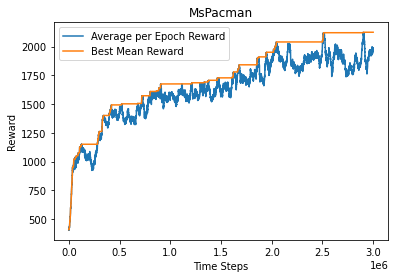

In [16]:
#@title plot learning curves

# plot results
rl_logger.plot(env.spec._env_name)

### Questions

1. Try learning without the target network. What do you observe?
2. Play with the hyperparameters to see if you can substantially improve the performance of the algorithm. 
3. Implement Double DQN; Does it perform better?
4. Check if the Q-network makes correct predictions, i.e. if the predicted expected return matches the observed values.
5. Try out Boltzmann exploration, where instead of an $\varepsilon$-greedy policy, one can use $\pi_\beta\propto \exp(Q(s,a)/T)$ for some temperature $T$ which follows some decay schedule. 